# DATASET과 DATALOADER
가독성, 모듈성을 위해 데이터셋 코드를 모델 학습 코드로 부터 분리하는 것이 이상적.<br>
- pytorch는 torch.utils.data.DataLoader와 torch.utils.data.Dataset 두 가지 데이터 기본요소를 제공, pre_loaded 데이터셋과 가지고 있는 데이터를 사용할 수 있도록 함.
- Dataset은 샘플과 정답(label)을 저장, Dataloader는 Dataset을 샘플에 쉽게 접근할 수 있도록 iterable(순회가능)객체로 감싼다

## 데이터셋 불러오기
- TorchVision에서 Fashion-MNIST 데이터셋 불러오기<br>
Fashion-MNIST : 이미지 데이터셋 (60,000개의 학습 예제, 10,000개의 테스트 예제)<br>
각 예제는 흑백 28*28 이미지와 10개 분류 중 하나인 정답(label)으로 구성


In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
training_data = datasets.FashionMNIST(
    root = 'data2',        # 학습/테스트 데이터가 저장되는 경로
    train = True,          # 학습용 or 테스트용 데이터셋 여부 지정
    download = True,       # 지정된 root에 데이터가 없는 경우 인터넷에서 다운로드
    transform = ToTensor() # transform 과 target_transform 은 특징(feature)과 정답(label) 변형(transform)을 지정합니다.
)

test_data = datasets.FashionMNIST(
    root = 'data2',
    train = False,
    download = True,
    transform = ToTensor()
)

100%|██████████| 26421880/26421880 [00:04<00:00, 5351176.91it/s]


Extracting data2\FashionMNIST\raw\train-images-idx3-ubyte.gz to data2\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 105617.57it/s]


Extracting data2\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data2\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:02<00:00, 1937280.74it/s]


Extracting data2\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data2\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<?, ?it/s]

Extracting data2\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data2\FashionMNIST\raw



## 데이터셋 순회 및 시각화
Dataset에 list처럼 접근(index)할 수 있음

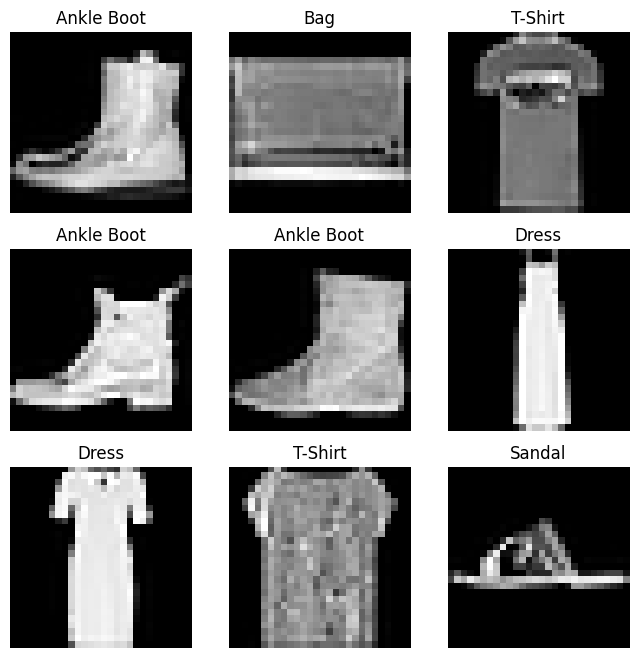

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## 사용자 정의 데이터셋 생성
사용자 정의 Dataset클래스는 아래 3개 함수를 구현해야 함
- __ init __
- __ len __
- __ getitem __

In [6]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):

    # __init__함수는 Dataset 객체 생성시 한 번만 실행.
    #이미지, 주석파일이 포함된 디렉토리와 2가지 변형(3_transfrom에서 확인)을 초기화
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    # __len__함수는 데이터셋의 샘플 개수를 반환
    def __len__(self):
        return len(self.img_labels)

    # __getitem__ 함수는 주어진 인덱스에 해당하는 샘플을 데이터셋에서 불러오고 반환,
    # 인덱스 기반, 디스크에서 이미지 위치를 식별
    # read_image를 사용하여 이미지를 텐서로 변환  
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)

        # self.img_labels의 csv데이터로 부터 해당하는 정답(label)을 가져오고,
        label = self.img_labels.iloc[idx, 1]
        # transform함수를 호출, 텐서 이미지와 라벨을 python dict형으로 반환
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        sample = {"image": image, "label": label}
        return sample

## DataLoader로 학습용 데이터 준비
Dataset은 데이터셋의 특징(feature)을 가져오고 하나의 샘플에 정답을 지정하는 일을 한 번에 함.<br>
모델 학습시 일반적으로 샘플을 미니배치로 전달, epoch마다 데이터를 섞어 과적합 방지<br>
DataLoader 는 간단한 API로 복잡한 과정을 추상화한 iterable(순회가능)객체.

In [7]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## DataLoader를 통해 iterate
DataLoader에 데이터셋을 불러온 후 데이터셋을 순회 가능.<br>
각 순회는 batch_size=64 의 feature, label을 포함하는 train_features 와 train_labels 의 묶음(batch)을 반환. <br>
shuffle=True 로 지정했으므로, 모든 배치를 순회한 뒤 데이터가 섞입니다. 

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


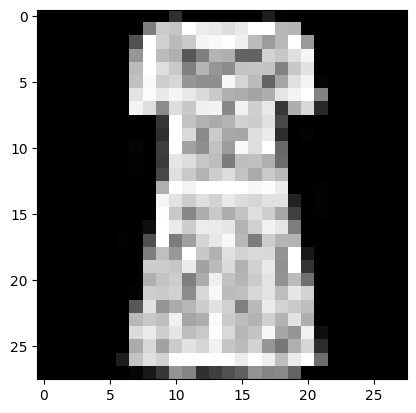

Label: 3


In [12]:
# 이미지와 정답(label)을 표시합니다.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")